In [32]:
from ..mlops import CombPurgedKFoldCV

ImportError: attempted relative import with no known parent package

In [27]:
df_train = pd.read_csv('/home/sam/github/finance-data-driven/data/processed/synthetic_ticker_data.csv')

n_splits=6
n_test_splits=2
time_gap = 100
embargo_td = 2

cpkf = CombPurgedKFoldCV(n_splits=n_splits, n_test_splits=n_test_splits, embargo_td=embargo_td)

t1_ = df_train.index
t1 = pd.Series(t1_).shift(time_gap).fillna(0).astype(int)
t2 = pd.Series(t1_).shift(-time_gap).fillna(1e12).astype(int)

splits = list(cpkf.split(df_train, pred_times=t1, eval_times=t2))

/tmp/ipykernel_56066/3005209260.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


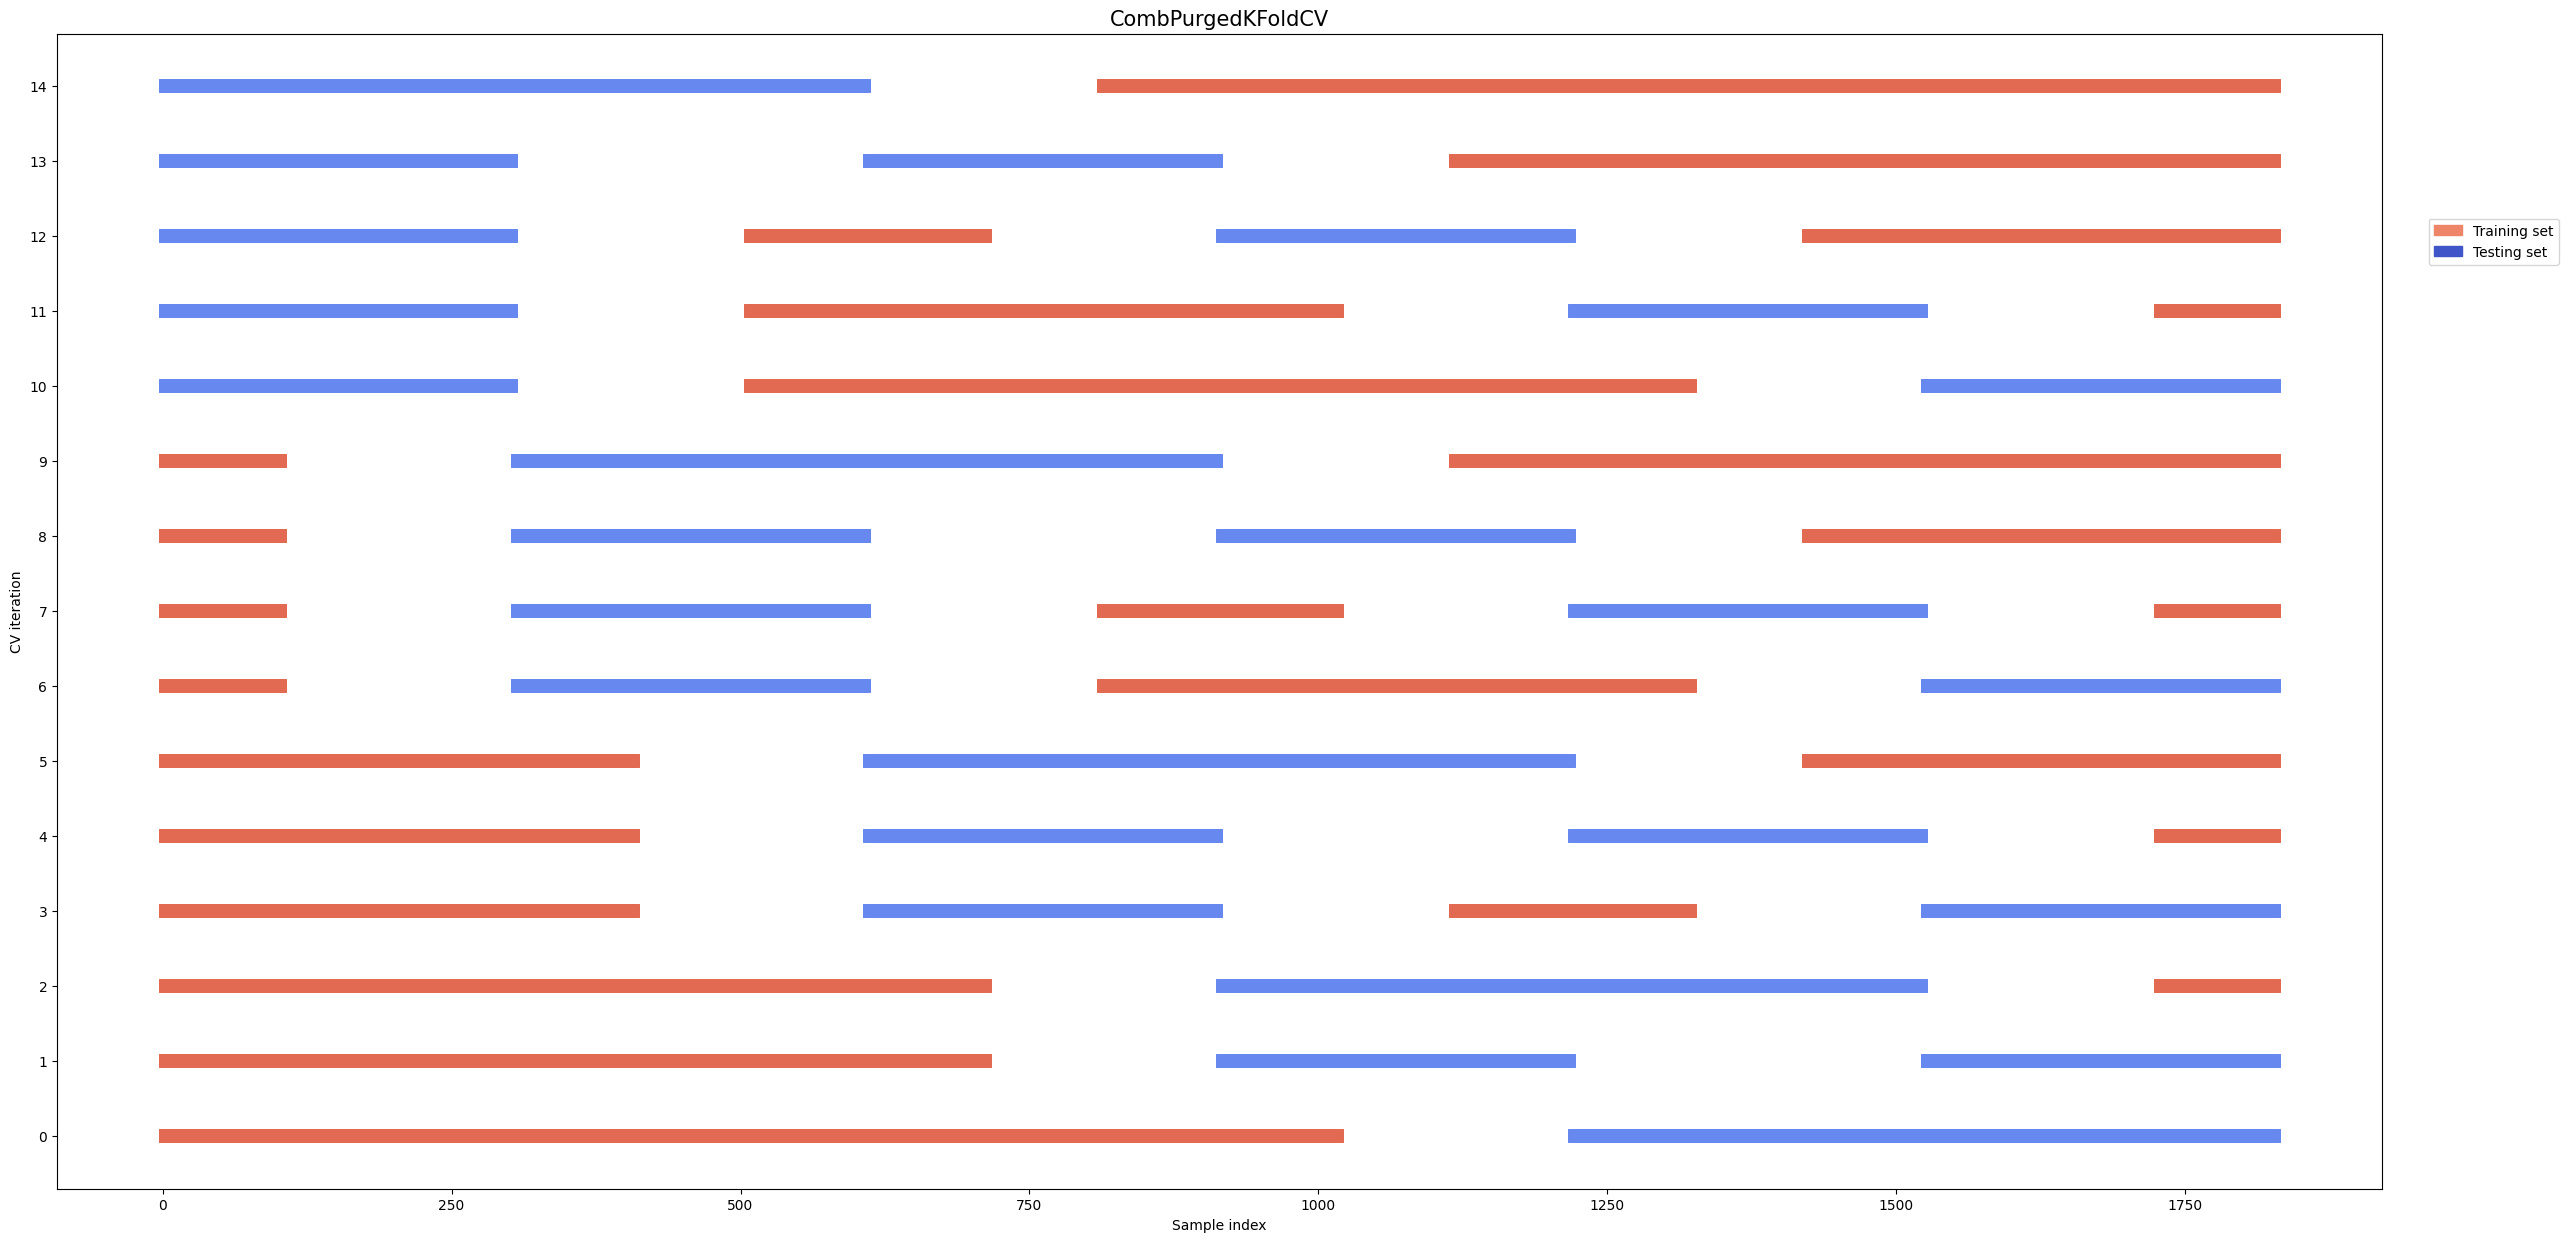

In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(111)

for ii, split in enumerate(splits):  
    indices = np.array([np.nan] * len(dtrain.iloc[:10000]))
    indices[split[0]] = 1
    indices[split[1]] = 0

    ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                       c=indices, marker='_', lw=10, cmap=cmap_cv,
                       vmin=-.2, vmax=1.2)

yticklabels = list(range(len(splits)))

ax.set(yticks=np.arange(len(splits)) + .5, yticklabels=yticklabels, xlabel='Sample index', ylabel="CV iteration")
ax.set_title('CombPurgedKFoldCV', fontsize=15)

ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))], ['Training set', 'Testing set'], loc=(1.02, .8))

fig.show()